# Exploración de BBDD. 

1. Baeza, Javiera. 
2. Deneken, Matías. 
3. Pampaloni, Florencia. 

Un reingreso hospitalario es un episodio cuando un paciente que había sido dado de alta de un hospital es admitido de nuevo dentro de un intervalo de tiempo especificado. Las tasas de readmisión se han utilizado cada vez más como medida de resultado en la investigación de servicios de salud y como referencia de calidad para los sistemas de salud. 

La idea de este proyecto es predecir si un paciente con diabetes va a ser readmitido a un hospital en función de 127 atributos (edad, sexo, tiempo en el hospital, medicamentos, etc.)
Datos: http://bit.ly/1aZzTmO


## Usar librerías

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Base de datos

In [3]:
# Cargar los datos
data = pd.read_csv('bbdd/diabetic_data.csv')  # Reemplazar con la ruta correcta del archivo CSV

In [4]:
# Exploración de variabeles
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Las variables que tienen valores perdidos son:

* race
* weight
* payer_code
* medical_specialty
* diag_1
* diag_2
* diag_3

| Categoría                                | Variables                                                                                                                                                                                                                                                                                                                                                          |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Variables Demográficas**               | `race`, `gender`, `age`, `weight`                                                                                                                                                                                                                                                                                                                                 |
| **Variables de Identificación**          | `encounter_id`, `patient_nbr`                                                                                                                                                                                                                                                                                                                                     |
| **Variables de Admisión y Alta**         | `admission_type_id`, `discharge_disposition_id`, `admission_source_id`, `time_in_hospital`                                                                                                                                                                                                                                                                         |
| **Variables Financieras**                | `payer_code`                                                                                                                                                                                                                                                                                                                                                      |
| **Variables Relacionadas con el Proveedor Médico** | `medical_specialty`                                                                                                                                                                                                                                                                                                                                               |
| **Variables de Diagnóstico**             | `diag_1`, `diag_2`, `diag_3`, `number_diagnoses`                                                                                                                                                                                                                                                                                                                   |
| **Variables de Procedimientos y Medicación**  | `num_lab_procedures`, `num_procedures`, `num_medications`, `number_outpatient`, `number_emergency`, `number_inpatient`                                                                                                                                                                                                                                             |
| **Variables Relacionadas con Resultados de Pruebas** | `max_glu_serum`, `A1Cresult`                                                                                                                                                                                                                                                                                                                                      |
| **Variables de Tratamiento Farmacológico (Medicamentos Específicos)** | `metformin`, `repaglinide`, `nateglinide`, `chlorpropamide`, `glimepiride`, `acetohexamide`, `glipizide`, `glyburide`, `tolbutamide`, `pioglitazone`, `rosiglitazone`, `acarbose`, `miglitol`, `troglitazone`, `tolazamide`, `examide`, `citoglipton`, `insulin`, `glyburide-metformin`, `glipizide-metformin`, `glimepiride-pioglitazone`, `metformin-rosiglitazone`, `metformin-pioglitazone` |
| **Variables de Cambio en Tratamiento y Medicación** | `change`, `diabetesMed`                                                                                                                                                                                                                                                                                                                                           |
| **Variable de Resultado Clínico**        | `readmitted`                                                                                                                                                                                                                                                                                                                                                      |


La readmisión nos señala esto: 

	Days to inpatient readmission. Values: <30 if the patient was readmitted in less than 30 days, >30 if the patient was readmitted in more than 30 days, and No for no record of readmission.


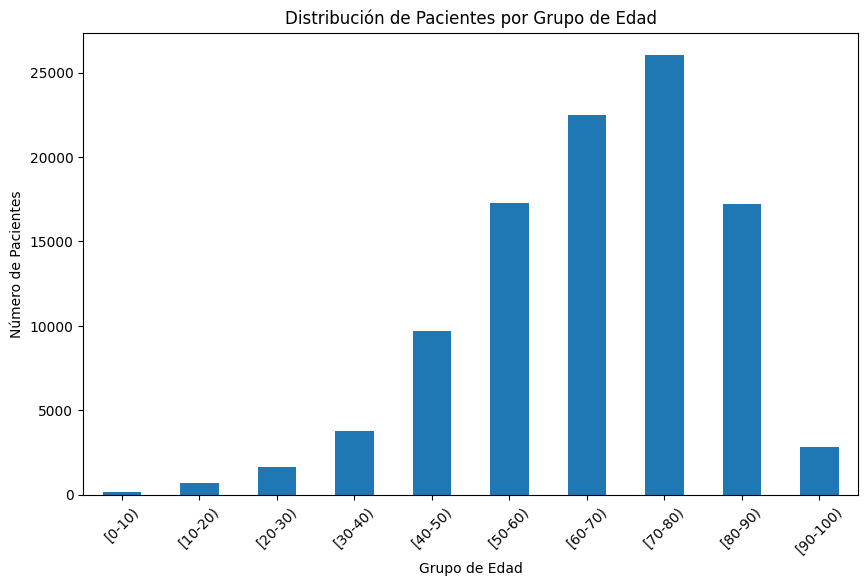

In [8]:
# Gráfico 1: Distribución de pacientes por grupo de edad
plt.figure(figsize=(10, 6))
data['age'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Pacientes por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Pacientes')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

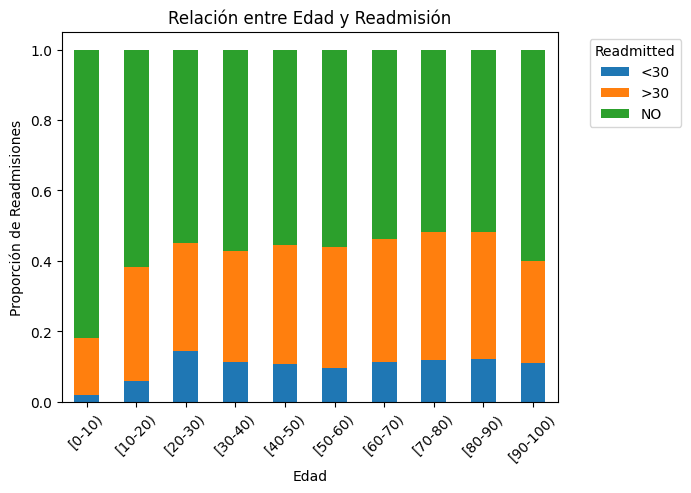

In [15]:
# Crear una tabla de proporciones de readmisión por grupo de edad
age_readmit = data.groupby('age')['readmitted'].value_counts(normalize=True).unstack()

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
age_readmit.plot(kind='bar', stacked=True)
plt.title('Relación entre Edad y Readmisión')
plt.xlabel('Edad')
plt.ylabel('Proporción de Readmisiones')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

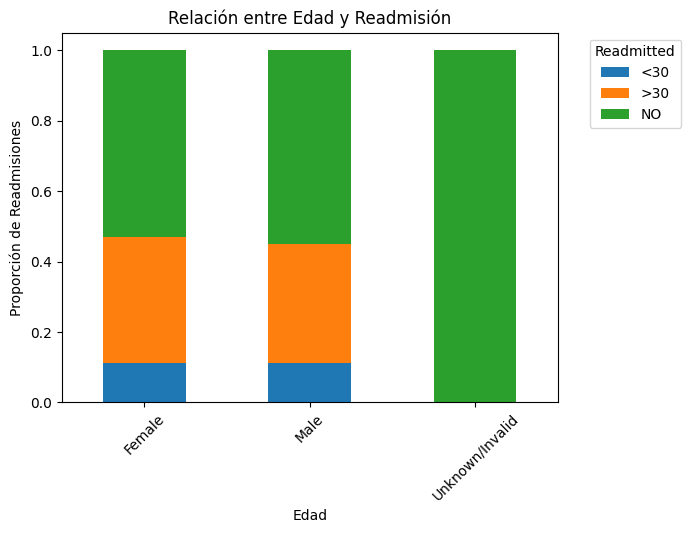

In [20]:
# Crear una tabla de proporciones de readmisión por grupo de edad
gender_readmit = data.groupby('gender')['readmitted'].value_counts(normalize=True).unstack()

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
gender_readmit.plot(kind='bar', stacked=True)
plt.title('Relación entre Edad y Readmisión')
plt.xlabel('Edad')
plt.ylabel('Proporción de Readmisiones')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()

/var/folders/hg/s4skq8ks6g1fy2jw2fdkp0840000gn/T/ipykernel_51195/3165689373.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_group_readmit = data.groupby('medication_group')['readmitted'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

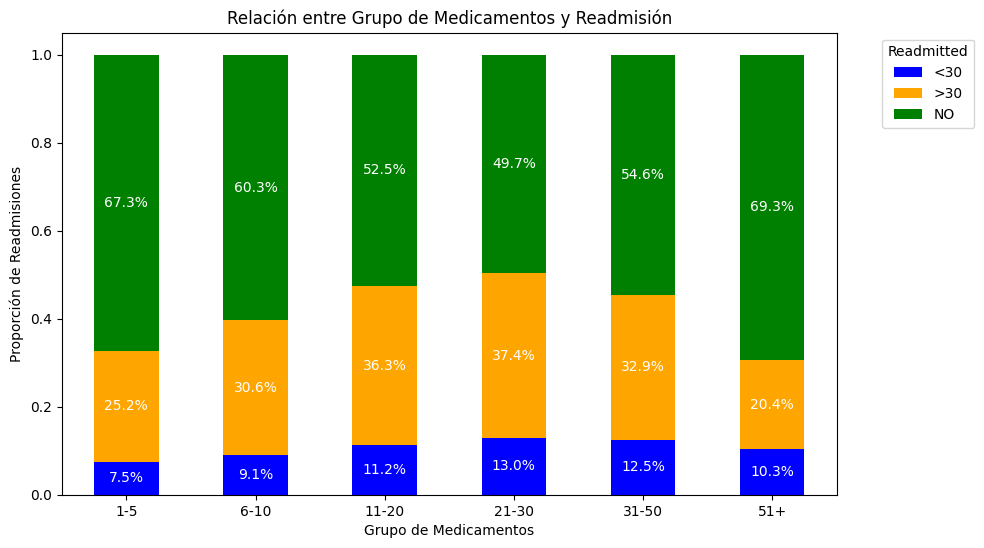

In [14]:
# Gráfico 1: Relación entre número de medicamentos y readmisión
# Agrupar el número de medicamentos en categorías
bins = [0, 5, 10, 20, 30, 50, 100]  # Definir los rangos para agrupar
labels = ['1-5', '6-10', '11-20', '21-30', '31-50', '51+']  # Etiquetas para los grupos
data['medication_group'] = pd.cut(data['num_medications'], bins=bins, labels=labels, right=False)

# Crear el gráfico con las nuevas categorías y añadir porcentajes
plt.figure(figsize=(10, 6))
med_group_readmit = data.groupby('medication_group')['readmitted'].value_counts(normalize=True).unstack()
bar_plot = med_group_readmit.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'orange', 'green'])
plt.title('Relación entre Grupo de Medicamentos y Readmisión')
plt.xlabel('Grupo de Medicamentos')
plt.ylabel('Proporción de Readmisiones')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)

# Añadir porcentajes a las barras
for p in bar_plot.patches:
    height = p.get_height()
    if height > 0:
        bar_plot.annotate(f'{height * 100:.1f}%', 
                          (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                          ha='center', va='center', fontsize=10, color='white')

plt.show()

<Figure size 1000x600 with 0 Axes>

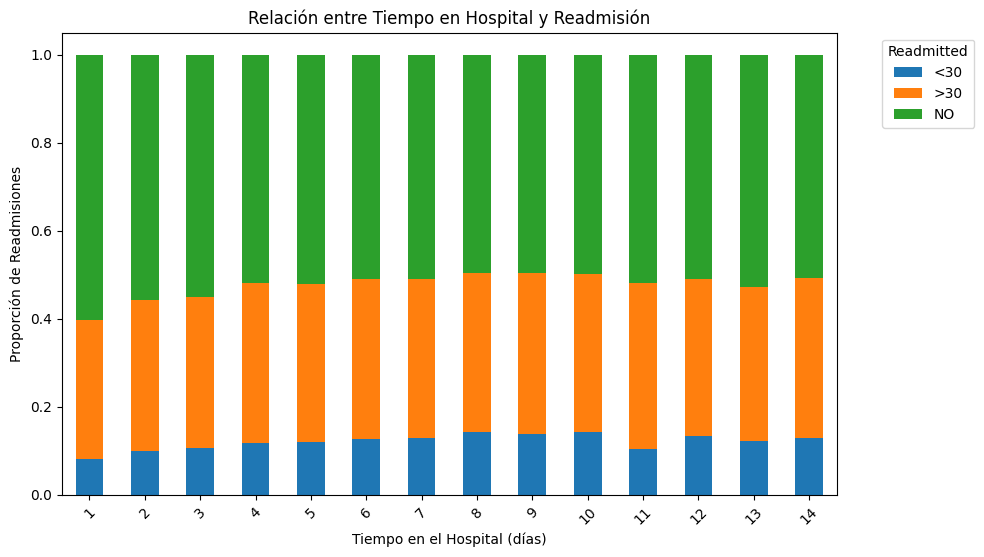

In [22]:
# Gráfico 2: Relación entre tiempo en hospital y readmisión
plt.figure(figsize=(10, 6))
time_readmit = data.groupby('time_in_hospital')['readmitted'].value_counts(normalize=True).unstack()
time_readmit.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Relación entre Tiempo en Hospital y Readmisión')
plt.xlabel('Tiempo en el Hospital (días)')
plt.ylabel('Proporción de Readmisiones')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()


<Figure size 1000x600 with 0 Axes>

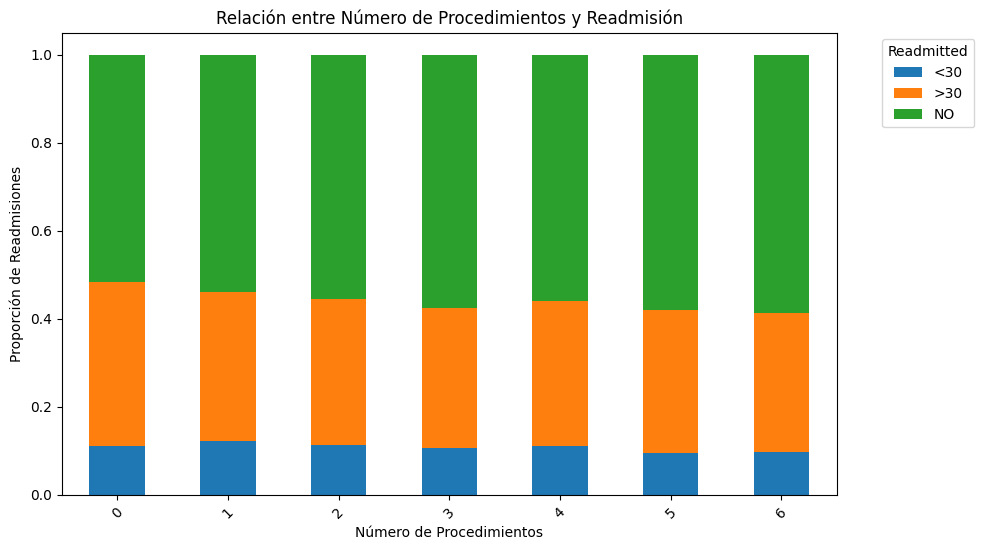

In [13]:
# Gráfico 3: Relación entre número de procedimientos y readmisión
plt.figure(figsize=(10, 6))
proc_readmit = data.groupby('num_procedures')['readmitted'].value_counts(normalize=True).unstack()
proc_readmit.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Relación entre Número de Procedimientos y Readmisión')
plt.xlabel('Número de Procedimientos')
plt.ylabel('Proporción de Readmisiones')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Seleccionar variables de interés
variables_interes = [
    'age', 'gender', 'time_in_hospital', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
    'insulin', 'diabetesMed', 'readmitted'
]

# Filtrar el dataset para mantener solo estas variables
data_filtered = data[variables_interes]

# Convertir variables categóricas a numéricas (por ejemplo, con pd.get_dummies)
data_numeric = pd.get_dummies(data_filtered, drop_first=True)

# Crear mapa de calor de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlación entre Variables Seleccionadas')
plt.show()

In [ ]:
# Crear gráfico de barras para el número de diagnósticos y la proporción de readmisión
diagnoses_readmit = data.groupby('number_diagnoses')['readmitted'].value_counts(normalize=True).unstack()
diagnoses_readmit.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Número de Diagnósticos y Proporción de Readmisión')
plt.xlabel('Número de Diagnósticos')
plt.ylabel('Proporción de Readmisiones')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.show()
